## Dimensionality reduction

We generally want to reduce dimensionality for one a few reasons:
1. We want to make our model more interpretable; reducing the features to the most important ones helps us reason about our data.
2. "Expense"

  a. If data collection is expensive, we want to make sure that each feature is worth the cost of obtaining it. (This is more for pilot studies; if you have the data already you may as well use it!)
  
  b. You are using algorithms that don't scale well with the number of features, so you want to reduce the number of inputs.
  
3. You want to visualize your data.

We have already learned LASSO (L1) regularization as a way of eliminating features altogether from your dataset. Lasso will generally help with 1, 2a, and 2b, but is less useful for point 3 as you don't want to fundamentally change your model just for a visualization.

PCA helps address 2b and 3 by selecting _linear combinations of features_ that are most important to your problem. You still need to collect all the features to begin with, and then PCA will "mix them up" for you.

Let's see an example of it in action on a toy dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

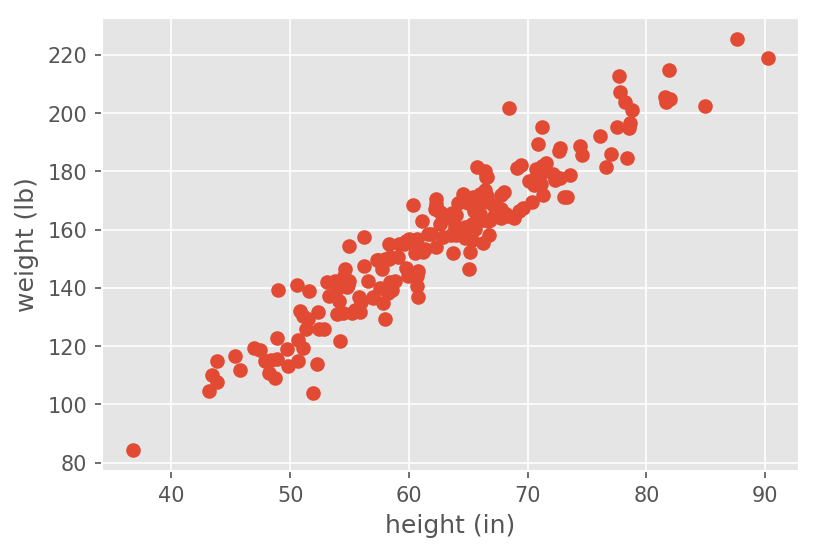

In [2]:
# Let's make a distribution of heights
np.random.seed(42)

height = np.random.normal(loc = 63, scale=10,size=(200,1))

# Now let's make a distribution of weights, and assume
# weight ~ 2.5 * height + noise
weight = 2.5*height + np.random.normal(loc=0, scale=8, size=(200,1))

plt.figure(dpi=150)
plt.plot(height, weight, 'o')
plt.xlabel('height (in)')
plt.ylabel('weight (lb)');

If our goal is to use height as a feature to predict weight, we would now try and use a **Linear Regression** model.

If we are using **PCA**, we have height and weight as two features. Maybe we are using these featuers to predict blood pressure, or lung capacity of some other quantity. Because these two features are highly correlated, we don't get that much information by putting both height and weight into our model. 

In this simple case, we could probably get away with putting in either one. We know from the way we generated the data that the "meaningful" feature is where we lie along the line `weight = 2.5 height + noise`.

This way of writing our line is still confusing, because it looks like we are asking for weight in terms of height. Instead, let's write a feature matrix `X` that is 200 x 2
```python
X = [[height, weight]]
```
Our line is then
```python
X[1] - 2.5 X[0] = 0 (+ noise)
```
i.e almost all of our points will have `X[1] - 2.5 X[0] \approx 0`. The interest is in what happens in the orthogonal direction, `2.5 X[1] + X[0]  = 0`. We will see this is a moment.

In [3]:
# Make our feature matrix

X = np.concatenate([height, weight], axis=1)
X

array([[ 67.96714153, 172.78015271],
       [ 61.61735699, 158.52966868],
       [ 69.47688538, 182.3566234 ],
       [ 78.23029856, 204.00616283],
       [ 60.65846625, 140.62481069],
       [ 60.65863043, 144.14397576],
       [ 78.79212816, 201.10060253],
       [ 70.67434729, 180.79615584],
       [ 58.30525614, 149.88352184],
       [ 68.42560044, 201.88585301],
       [ 58.36582307, 150.48168177],
       [ 58.34270246, 154.94128128],
       [ 65.41962272, 171.1810709 ],
       [ 43.86719755, 114.87912389],
       [ 45.75082167, 111.85490023],
       [ 57.37712471, 149.51456553],
       [ 52.8716888 , 125.99662028],
       [ 66.14247333, 163.46163446],
       [ 53.91975924, 130.91648973],
       [ 48.87696299, 122.84740058],
       [ 77.65648769, 212.65848776],
       [ 60.742237  , 136.91747095],
       [ 63.67528205, 164.67828664],
       [ 48.75251814, 108.97956838],
       [ 57.55617275, 140.11497696],
       [ 64.1092259 , 168.98466952],
       [ 51.49006423, 129.23940072],
 

We first center the data, so it is around zero. It has the same shape overall:

Text(0,0.5,'weight - ave weight')

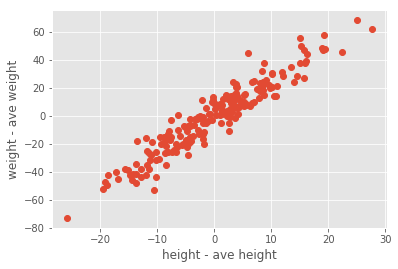

In [4]:
X_centered = X - X.mean(axis = 0)
plt.plot(X_centered[:, 0], X_centered[:, 1],'o');
plt.xlabel('height - ave height')
plt.ylabel('weight - ave weight')

We can find the convariance matrix of `X` as `cov(X) = X_centered.T  X_centered`, where multiplication is matrix multiplication

In [5]:
covX = np.matmul(X_centered.T, X_centered) # NOT x_centered.T * x_centered
covX 

array([[ 17248.6889736 ,  44513.61923663],
       [ 44513.61923663, 127170.9022947 ]])

i.e. the variance of `X[0]` is 17248.7, and the variance of `X[1]` is 127170.9

Our goal is to find the "direction" in feature space (that is, height and weight) that has the most variation along it, as that carries most of differences between different examples. 

In [6]:
eigenvalues, eigenvectors = np.linalg.eig(covX)

This weird command gives us two things:
- a list of variances in `eigenvalues`, such that `eigenvalues[i]` is the variance in "direction" `i`.
- a matrix `eigenvectors`, which define the "directions": `eigenvector[:, i]` is the direction that has variance `i`.

This basis diagonalizes the covariance matrix, which means that each of the special directions can be assigned a variance, largely ignoring what happens in the other dimensions (sort of ....)

In [7]:
# What are the variances?
eigenvalues

array([  1483.66508189, 142935.92618641])

Notice that the variation in the "1" position is much greater than the variation in the "0" position. 

In [11]:
#print(np.dot(eigenvectors[:, 0], eigenvectors[:,1]))
#eigenvectors
eigenvectors[:, 1]

array([-0.33384307, -0.94262867])

Let's plot these two vectors, along with our data

(-30, 30)

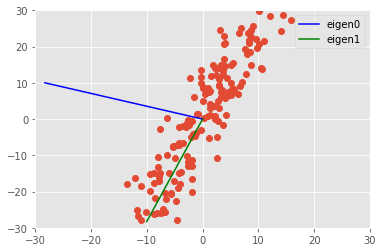

In [12]:
plt.plot(X_centered[:, 0], X_centered[: ,1], 'o')
plt.plot([0, 30*eigenvectors[0,0]], [0, 30*eigenvectors[1,0]], 'b-', label='eigen0')
plt.plot([0, 30*eigenvectors[0,1]], [0, 30*eigenvectors[1,1]], 'g-', label='eigen1')
plt.legend()
plt.xlim(-30,30)
plt.ylim(-30,30)

We can see that the direction "eigen1" (the direction with the big eigenvalue) is the one that points along the line, so we only need to keep the data along this direction. 

`eigen1` and `eigen0` are the **principle components** (directions) in this dataset.

Let's see how we keep data in only one direction (the `eigen1` direction)

In [14]:
# keep only data in `eigen1` direction:
X_centered_project = np.dot(X_centered, eigenvectors[: ,1]).reshape(-1,1)
X_centered_recover = np.dot(X_centered_project, eigenvectors[:,1].reshape(1,-1))

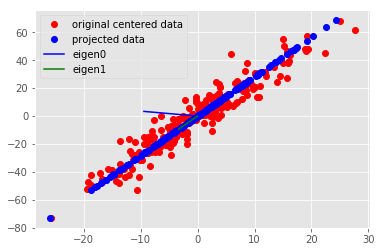

In [15]:
plt.plot(X_centered[:, 0], X_centered[: ,1], 'ro', label = 'original centered data')
plt.plot(X_centered_recover[:, 0], X_centered_recover[:, 1], 'bo', label='projected data')

plt.plot([0, 10*eigenvectors[0,0]], [0, 10*eigenvectors[1,0]], 'b-', label='eigen0')
plt.plot([0, 10*eigenvectors[0,1]], [0, 10*eigenvectors[1,1]], 'g-', label='eigen1')
plt.legend()


### What were the steps for doing PCA on covariance matrix?

1. Center the features, `X_center`
2. Find the covariance matrix, which describes how spread the data is in each direction using `np.matmul(X_center.T, X_center)`
3. Find the principal components and special directions using `np.linalg.eig`
4. Choose the highest variance directions in your data (these are the directions that have the most difference between different examples). Sort the eignvectors by the eigenvalues.
5. Project your data onto the `n` most important dimensions using
```python
# assumes eigenvectors has been sorted from smallest eigenvalue to largest using
# something like np.argsort
X_project = np.matmul(X_center, eigenvectors[:, -n]) 
```
6. Use `X_project` for your features.


Note: You won't actually do the steps above - you'll either use SVD or the built-in PCA. This is to give some idea what SVD is actually doing!

## SVD

We can bypass constructing the covariance matrix using _singular value decomposition_. Suppose we have `f` features and `m` rows, and there are `r` the number of principal in the data.

We can take our centered data and write

$$X_{\text{centered}} = U \Sigma V^T$$

where 
- $U$ is 
- $\Sigma$ is diagonal `rxr`, and tells us the standard deviation along each principal axes.
- $V$ is `f x r`, so each column is a principle component vector.

The command `np.linalg.svd(X_centered)` extracts these matrices:

In [16]:
U, s, Vt = np.linalg.svd(X_centered)

In [17]:
# This gives us the original eigenvectors. They are ordered 
# from most important (highest variance) to lease
Vt.T

array([[-0.33384307,  0.94262867],
       [-0.94262867, -0.33384307]])

In [18]:
# Note these are the same columns, but in a different order
eigenvectors

array([[-0.94262867, -0.33384307],
       [ 0.33384307, -0.94262867]])

In [19]:
# s is the standard deviation in each of the principle directions. Note how the largest 
# variance direction comes first
s*s

array([142935.92618641,   1483.66508189])

In [20]:
# same values but swapped (like the eigenvectors)
eigenvalues

array([  1483.66508189, 142935.92618641])

In [21]:
# To project out the most important direction:
projection = Vt.T[:, :1]
X_centered_project = np.matmul(X_centered, projection )

In [22]:
# To recover original space
X_centered_recover = np.matmul(X_centered_project, projection.T)

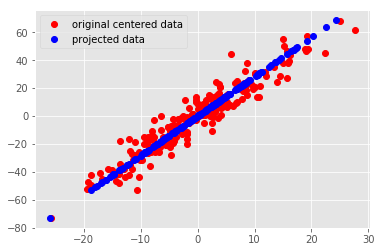

In [23]:
plt.plot(X_centered[:, 0], X_centered[: ,1], 'ro', label = 'original centered data')
plt.plot(X_centered_recover[:, 0], X_centered_recover[:, 1], 'bo', label='projected data');
plt.legend(loc='upper left')

### Steps for SVD:

1. Center the data
2. Calculate the SVD decomposition:
```python
U, s, Vt = np.linalg.svd(X_centered)
```
3. Unlike eigenvalues, the columns are already ordered. Decide on how many principle directions you want to keep (`n`) and project the data:
```python
# keep the first n columns of V = Vt.T
projection = Vt.T[:n]
X_centered_project = np.matmul(X_centered, projection)
```
4. Use `X_centered_project` in your models / visualization.

You can take the projected data and put it back in the original space using
```python
X_centered_recovered = np.matmul(X_centered_project, projection.T)
```

## Explained variance ratio

Our simple toy example only has two features: height and weight. If we are going to do dimensionality reduction, our only real choice is to reduce down to one dimension. We could ask how we can measure what we give up by doing that. The typical idea is the _explained variance ratio_.

For example, in our two principle directions, we have a covariance matrix

In [24]:
print("Variance matrix is " + str(s*s))
print("Total variance is " + str(sum(s*s)))

Variance matrix is [142935.92618641   1483.66508189]
Total variance is 144419.59126830025


If we keep only the direction with the most variance, we are tracking 
$$\frac{\text{Sum of variances in directions we are keeping}}{\text{total variance in dataset}} = \frac{142935.9}{144419.6} \approx 0.9897$$
i.e. 99% of the variance in our dataset. The "cost" of throwing away the extra dimension is not being able to explain the last 1% of the variation.

## PCA (i.e. the built in way)

Scikit-learn's has a built-in PCA that has a couple of neat features. We will show it again on the dataset we already have.

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 1)
X_centered_projected = pca.fit_transform(X)


Note that PCA will automatically center our data for us. We can recover the means:

In [26]:
pca.mean_

array([ 62.59229035, 157.16767137])

We can also get the `explained_variance_ratio` directly:

In [27]:
pca.explained_variance_ratio_

array([0.9897267])

We elected to keep one component of the data (n_components = 1). We can also project back to our original space (including undoing the centering)

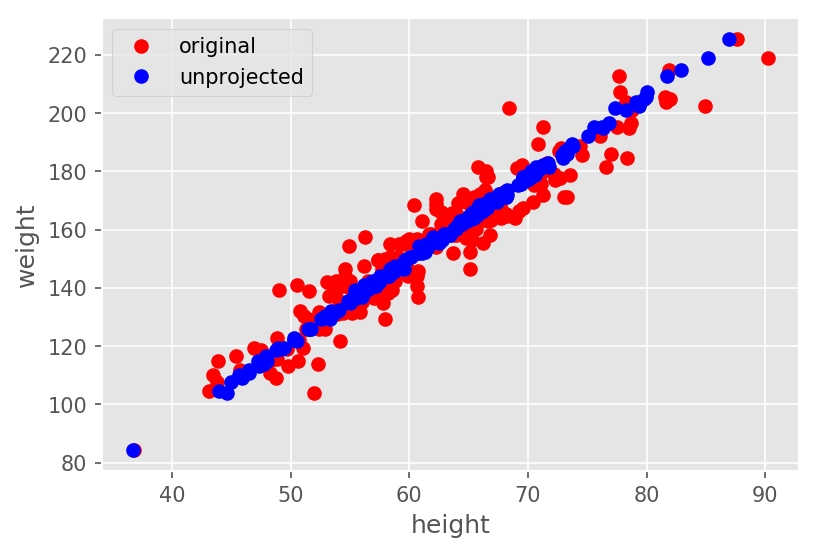

In [28]:

X_undo = pca.inverse_transform(X_centered_projected)

plt.figure(dpi=150)

plt.plot(X[:,0], X[:,1], 'ro', label='original')
plt.plot(X_undo[:,0], X[:, 1], 'bo', label='unprojected')
plt.xlabel('height')
plt.ylabel('weight')
plt.legend(loc='upper left');

We can also ask PCA for the eigenvectors:

In [29]:
pca.components_

array([[-0.33384307, -0.94262867]])

In [30]:
# Note that this matches the first row of Vt
# To use it to do the projection, we would want to take the projection of Vt.
Vt

array([[-0.33384307, -0.94262867],
       [ 0.94262867, -0.33384307]])

# A better toy dataset: MNIST

Let's see how this works on the MNIST dataset. Recall each image has 28 x 28 = 784 features. Let's see if we can reduce the dimensionality down

In [31]:
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

# You should be able to run this if you downloaded MNIST already.
# Server was down when I tried, so I am going to use load_digits instead
mnist = fetch_mldata("MNIST original")
X_digits = mnist.data
Y_digits = mnist.target

Don't run this cell if you can the cell above to work!

In [32]:
"""from sklearn.datasets import load_digits

mnist = load_digits()
X_digits = mnist.data
targets  = mnist.target"""

'from sklearn.datasets import load_digits\n\nmnist = load_digits()\nX_digits = mnist.data\ntargets  = mnist.target'

In [37]:
pca = PCA(n_components = 60)
pca.fit(X_digits)

PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [38]:
np.cumsum(pca.explained_variance_ratio_)

array([0.09746116, 0.16901561, 0.23051091, 0.28454476, 0.3334341 ,
       0.37648637, 0.40926898, 0.4381654 , 0.46574904, 0.48917044,
       0.51023733, 0.53061286, 0.5476835 , 0.5646237 , 0.58045752,
       0.59532097, 0.60851456, 0.6213047 , 0.63317742, 0.64470679,
       0.65536719, 0.66546513, 0.67505665, 0.684153  , 0.69298586,
       0.70137405, 0.70947236, 0.71732954, 0.72473217, 0.73163231,
       0.73819375, 0.74464845, 0.75065664, 0.75651276, 0.7621803 ,
       0.767615  , 0.77266217, 0.77753296, 0.78232251, 0.78699845,
       0.79154213, 0.79599131, 0.80017346, 0.80413509, 0.80797213,
       0.81172993, 0.81534412, 0.81883399, 0.82222118, 0.82541783,
       0.82858626, 0.83168697, 0.83465161, 0.8375204 , 0.84034192,
       0.84303447, 0.84571759, 0.84827492, 0.8507951 , 0.85323201])

i.e. the first 60 components account for 85% of the variance. Plotting it out:

Text(0,0.5,'Explained variance')

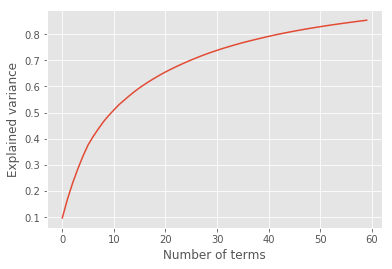

In [39]:
cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative)
plt.xlabel('Number of terms')
plt.ylabel('Explained variance')

Let's say we wanted to explain 95% of the variance:

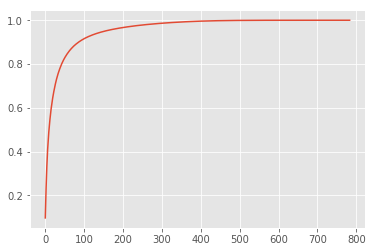

In [40]:
pca = PCA(n_components=784)
pca.fit(X_digits)
cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative)

In [41]:
# find 95% 
index = np.argmax(cumulative > 0.95) + 1
index, cumulative[index]

(154, 0.950797142697462)

i.e. 154 components gets us to 95.1% of the variance.

Turns out there is a better way:

In [75]:
pca2 = PCA(n_components=80)
pca2.fit(X_digits)

PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [76]:
X2 = pca2.transform(X_digits)

In [53]:
X2.shape

(70000, 70)

How do these images compare? Let's try drawing the original image

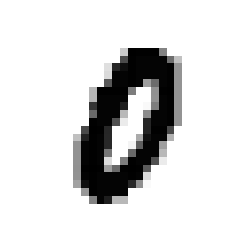

In [54]:
plt.rc("image", cmap="binary")

# this assumes the matrices are square
def draw_image(datapoint):
    datapoint = datapoint.reshape(1, -1)
    L = datapoint.shape[1]
    n = int(np.sqrt(L))
    im_matrix = datapoint.reshape(n,n)
    plt.xticks(())
    plt.yticks(())
    plt.imshow(im_matrix)

draw_image(X_digits[2])

In [61]:
def draw_compressed_image(datapoint, pca):
    plt.subplot(1,2,1)
    draw_image(datapoint)
    
    plt.subplot(1,2,2)
    transformed = pca.transform(datapoint.reshape(1, -1))
    restored = pca.inverse_transform(transformed)
    draw_image(restored)

In [69]:
Y_digits.shape[0]/10

7000.0

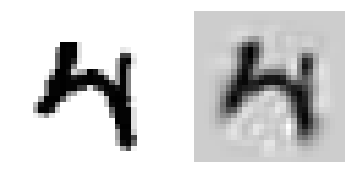

In [77]:
draw_compressed_image(X_digits[30000], pca2)

In [78]:
from PIL import Image
import sys
import numpy as np
import random
import os

image = Image.open('./cardinal-007.jpg', 'r')
width, height = image.size
pixel_values = np.array(image.getdata())


In [84]:
def process_channel(channel_data, height, width, frac=0.9):
    channel = channel_data.reshape(height, width)
    pca = PCA(n_components=frac)
    channel_reduced = pca.fit_transform(channel)
    channel_restore = pca.inverse_transform(channel_reduced)
    print("Number of dimensions kept: {} out of {}".format(channel_reduced.shape[1], channel_restore.shape[1]))
    return channel_restore.astype(int)

def process_image(pixel_values, height, width, frac=0.9):
    r_recon = list(process_channel(pixel_values[:, 0], height, width, frac).reshape(-1,))
    g_recon = list(process_channel(pixel_values[:, 1], height, width, frac).reshape(-1,))
    b_recon = list(process_channel(pixel_values[:, 2], height, width, frac).reshape(-1,))
    
    newImage = Image.new('RGB', (width, height))
    newPixels = [pixel for pixel in zip(r_recon, g_recon, b_recon)]
    
    newImage.putdata(newPixels)
    plt.figure(dpi=300)
    plt.xticks(())
    plt.yticks(())
    plt.imshow(newImage);
    

Number of dimensions kept: 129 out of 1024
Number of dimensions kept: 121 out of 1024
Number of dimensions kept: 105 out of 1024


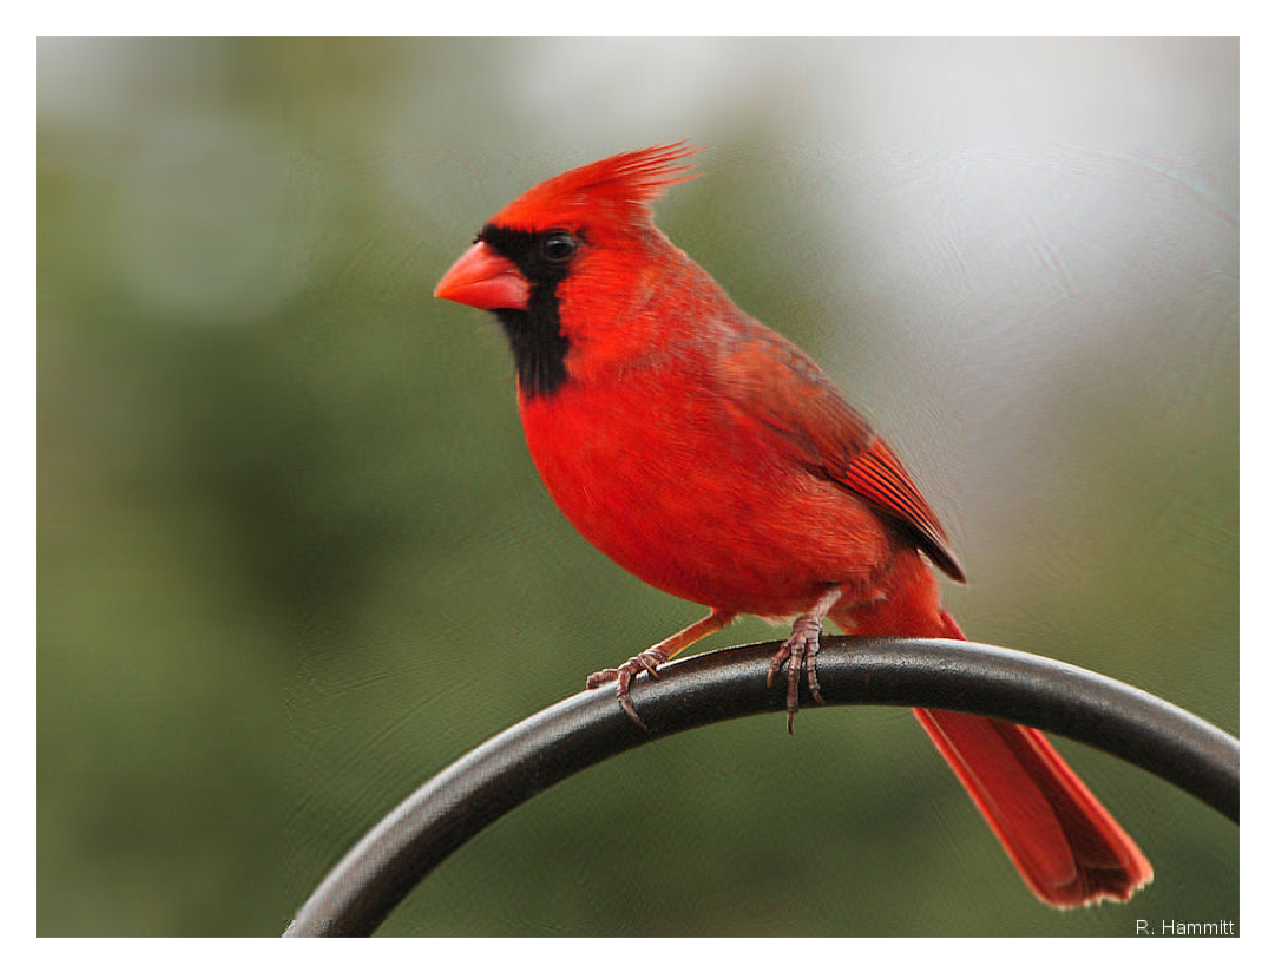

In [88]:
process_image(pixel_values, height, width, frac=0.99)